In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import lettuce as lt
from lettuce import D2Q9, Lattice, UnitConversion, BGKCollision, StandardStreaming, Simulation, IncompressibleKineticEnergy
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter


In [2]:
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, help="name base of vtk files - they are usually in a vtk-subdirectory!", default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--resolutionx", type=int, default=80)
parser.add_argument("--resolutiony", type=int, default=40)
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=100)
parser.add_argument("--tmax", type=int, default=100)
parser.add_argument("--Re", type=int, default=12000)
parser.add_argument("--collision_operator", type=str, default="BGK")
parser.add_argument("--Precision", type=str, default="Single")
parser.add_argument("--Mach", type=float, default=0.1)
args, unknown = parser.parse_known_args()
args = vars(args)
print("ICH FUNKTIONIERE MIT PULLEN")
Re=args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]
Precision= args["Precision"]
collision_operator = args["collision_operator"]
Mach = args["Mach"]
res_x = args["resolutionx"]
res_y = args["resolutiony"]

acceleration = np.array([1e-5, 0.0])  # Body Force in x-Richtung (Guo)


if Precision == "Single":
    dtype = torch.float32
elif Precision == "Double":
    dtype = torch.float64
elif Precision == "Half":
    dtype = torch.float16

ICH FUNKTIONIERE MIT PULLEN


steps     time     IncompressibleKineticEnergy
tensor([[[-4.6914e-06,  6.4624e-03,  1.7195e-02,  ...,  2.1478e-03,
          -3.6238e-04, -3.5579e-05],
         [-3.9251e-05,  6.3547e-03,  1.7223e-02,  ...,  1.4852e-03,
          -7.1994e-04, -2.2207e-05],
         [-4.2050e-05,  6.2531e-03,  1.7395e-02,  ...,  1.2431e-03,
          -5.7272e-04,  2.6531e-05],
         ...,
         [-8.1658e-06,  5.6485e-03,  1.6238e-02,  ...,  5.0418e-03,
           1.4968e-03,  1.7709e-05],
         [ 1.0988e-05,  5.9280e-03,  1.6711e-02,  ...,  4.3829e-03,
           9.7532e-04,  2.3441e-05],
         [ 1.8100e-05,  6.2792e-03,  1.7092e-02,  ...,  3.2831e-03,
           3.0564e-04, -6.4440e-06]],

        [[ 1.2040e-04, -2.9111e-05, -6.3089e-05,  ..., -8.5922e-04,
          -2.6963e-04, -1.5150e-04],
         [ 1.9506e-04, -1.5730e-04, -1.6294e-04,  ..., -5.8384e-04,
          -9.9577e-05, -1.5518e-04],
         [ 2.9251e-04, -1.6666e-04, -2.5229e-04,  ..., -4.3676e-04,
           1.3986e-04, -1.034

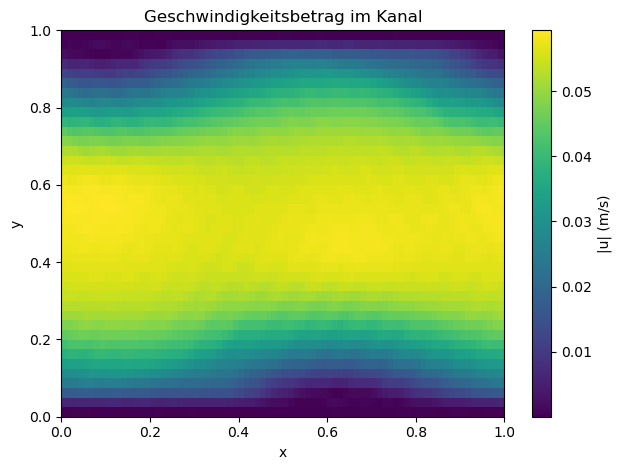

In [3]:

# --- 🧱 Lattice & Einheiten ---
lattice = Lattice(D2Q9, device="cuda", dtype=dtype)

flow = lt.ChannelFlow2D(
    resolution_x=res_x,
    resolution_y=res_y,
    reynolds_number=Re,
    mach_number=Mach,
    lattice=lattice,
    char_length_lu=res_y
)

# --- 🧱 Wände definieren ---
x, y = flow.grid  # physikalische Gitterkoordinaten

# y in LU umrechnen (nur nötig, falls du nach physikalischen Einheiten schneiden willst)
# Hier reicht aber die Indexierung direkt, da wir die äußersten Zeilen meinen:
mask = np.zeros_like(x, dtype=bool)
mask[:, 0] = True           # untere Wand (y=0)
mask[:, -1] = True          # obere Wand (y=max)

# Maske setzen
flow.mask = mask

# --- 🌀 Forcing (Guo) ---
from lettuce.force import Guo  # dein Guo-Code
forcing = Guo(lattice, tau=flow.units.relaxation_parameter_lu, acceleration=acceleration)

# --- 🔁 Setup Simulation ---
if collision_operator == "BGK":
    collision=lt.BGKCollision(lattice, tau=round(flow.units.relaxation_parameter_lu,7))
elif collision_operator == "KBC":
    collision=lt.KBCCollision3D(lattice, tau=flow.units.relaxation_parameter_lu)

streaming = StandardStreaming(lattice)
simulation = Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)

# --- 📊 Beobachter ---
Energy = IncompressibleKineticEnergy(lattice, flow)
reporter = lt.ObservableReporter(Energy, interval=100, out=None)
simulation.reporters.append(reporter)

vtk_reporter = lt.VTKReporter(
    lattice=lattice,
    flow=flow,
    interval=100,                    # alle 100 Zeitschritte ein VTK-Frame
    filename_base=basedir + "/output" # Basisname der Dateien
)
simulation.reporters.append(vtk_reporter)


# --- ▶️ Simulation starten ---
steps = int(flow.units.convert_time_to_lu(tmax))  # z.B. 5 Sekunden
mlups = simulation.step(num_steps=steps)
# --- 📈 Analyse ---
u = lattice.u(simulation.f) # u-Komponente
u_mean= torch.mean(u, dim=(1,0))

print(u) # Mittelung über x-Richtung

# Hole u_x-Komponente (Index 0)
u_numpy = u.cpu().numpy()  # [2, res_x, res_y]
u_mag = np.sqrt(u_numpy[0]**2 + u_numpy[1]**2)  # Geschwindigkeitbetrag

plt.imshow(u_mag.T, origin='lower', extent=[0, 1, 0, 1], aspect='auto')
plt.colorbar(label='|u| (m/s)')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Geschwindigkeitsbetrag im Kanal")
plt.tight_layout()
plt.show()
